In [1]:
import cudf
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statistics import mean
import numpy as np
import json

In [2]:
results = {
    "cpu": {},
    "gpu": {}
}

scale_factors = ["x0_1", "x0_5", "x1", "x5", "x10", "x20"]

### CPU

In [3]:
for scale_factor in scale_factors:
    results['cpu'][scale_factor] = {}
    results['cpu'][scale_factor]["io_opt"] = {}
    results['cpu'][scale_factor]["queries"] = {}

    start = time()
    cpu_df = pd.read_csv("../data/raw/online_retail_II_"+scale_factor+".csv")
    end = time()

    results["cpu"][scale_factor]["io_opt"]["load_csv"] = end-start

#     start = time()
#     cpu_df.info()
#     end = time()

#     results["cpu"][scale_factor]["io_opt"]["info"] = end-start

    start = time()
    cpu_df.describe(include="O")
    end = time()

    results["cpu"][scale_factor]["io_opt"]["describe"] = end-start

    start = time()
    cpu_df.groupby("Country").Price.sum()
    end = time()

    results["cpu"][scale_factor]["queries"]["q3"] = end-start

    start = time()
    cpu_df.groupby("Invoice").Price.sum()
    end = time()

    results["cpu"][scale_factor]["queries"]["q1"] = end-start

## GPU

In [4]:
for scale_factor in scale_factors:
    if scale_factor != "x20":
        results['gpu'][scale_factor] = {}
        results['gpu'][scale_factor]["io_opt"] = {}
        results['gpu'][scale_factor]["queries"] = {}

        start = time()
        gpu_df = cudf.read_csv("../data/raw/online_retail_II_"+scale_factor+".csv")
        end = time()

        results["gpu"][scale_factor]["io_opt"]["load_csv"] = end-start

#         start = time()
#         gpu_df.info()
#         end = time()

#         results["gpu"][scale_factor]["io_opt"]["info"] = end-start

        start = time()
        gpu_df.describe(include="O")
        end = time()

        results["gpu"][scale_factor]["io_opt"]["describe"] = end-start

        start = time()
        gpu_df.groupby("Country").Price.sum()
        end = time()

        results["gpu"][scale_factor]["queries"]["q3"] = end-start

        start = time()
        gpu_df.groupby("Invoice").Price.sum()
        end = time()

        results["gpu"][scale_factor]["queries"]["q1"] = end-start

### Join tests

In [5]:
# gpu_df = cudf.read_csv("../data/raw/online_retail_II_x1.csv")
# gpu_df_idx = cudf.read_csv("../data/raw/online_retail_II_indexes.csv")

In [6]:
# gpu_df = gpu_df.astype({"StockCode": "category"})
# gpu_df['StockCode'].values

In [7]:
# start = time()
# ix_col = "StockCode"
# target_cols = ["Invoice", "Price", "Quantity"]
# broadcasted_ix = gpu_df[ix_col].values
# broadcasted_df_ix = gpu_df_idx.set_index(ix_col).reindex(broadcasted_ix)
# join_df = gpu_df.concat([gpu_df, broadcasted_df_ix[target_cols]], axis=1, ignore_index=True)
# end = time()

# print(end-start)

## PLOTS

In [8]:
def plot(sf, cpu_io, gpu_io, cpu_queries, gpu_queries):
    # PLOT 1
    labels = ['Load\ndataset', '.describe()']
    # cpu_values = [i[1] for i in results["cpu"]["x1"]["io_opt"].items()]
    # gpu_values = [i[1] for i in results["gpu"]["x1"]["io_opt"].items()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax1 = plt.subplot(1, 2, 1)
    ax1.bar(x - width/2, cpu_io, width, label='CPU')
    ax1.bar(x + width/2, gpu_io, width, label='GPU')

    ax1.set_ylabel('seconds')
    ax1.set_title('I/O operations & Statistics')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend()

    # PLOT 2
    labels = ['Q1', 'Q3']
    # cpu_queries = [i[1] for i in results["cpu"]["x1"]["queries"].items()]
    # gpu_queries = [i[1] for i in results["gpu"]["x1"]["queries"].items()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    ax2 = plt.subplot(1, 2, 2)
    ax2.bar(x - width/2, cpu_queries, width, label='CPU')
    ax2.bar(x + width/2, gpu_queries, width, label='GPU')

    ax2.set_title('Queries')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    title = "Test with SF="+sf
    # plt.suptitle(title)

    plt.tight_layout()

    plt.savefig(f"../plots/{title}.png", dpi=100, bbox_inches='tight', pad_inches=0.1)
    plt.show()

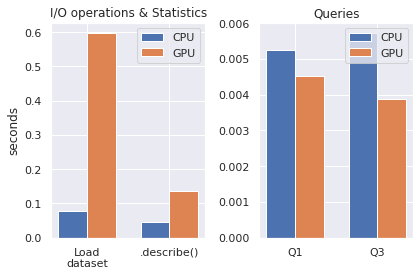

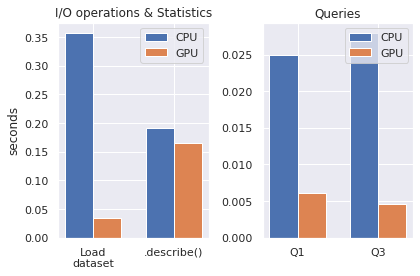

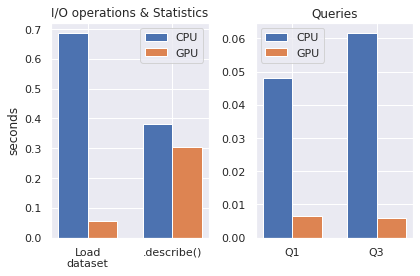

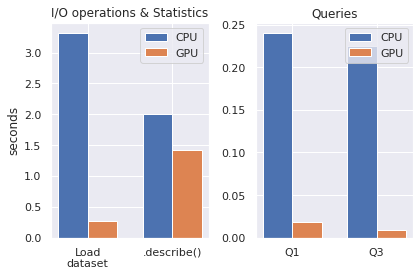

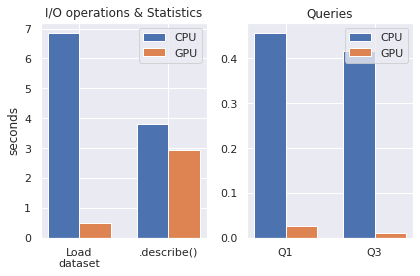

In [9]:
for scale_factor in scale_factors:
    if scale_factor != "x20":
        plot(
            scale_factor,
            [i[1] for i in results["cpu"][scale_factor]["io_opt"].items()],
            [i[1] for i in results["gpu"][scale_factor]["io_opt"].items()],
            [i[1] for i in results["cpu"][scale_factor]["queries"].items()],
            [i[1] for i in results["gpu"][scale_factor]["queries"].items()]
        )

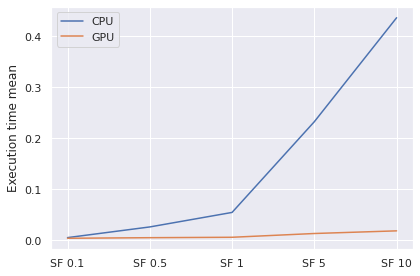

In [10]:
cpu = []
gpu = []

for scale_factor in scale_factors:
    if scale_factor != "x20":
        cpu.append(mean([i[1] for i in results["cpu"][scale_factor]["queries"].items()]))
        gpu.append(mean([i[1] for i in results["gpu"][scale_factor]["queries"].items()]))

activity = ["SF 0.1", "SF 0.5", "SF 1", "SF 5", "SF 10"]

fig, ax = plt.subplots()
ax.plot(activity, cpu, label="CPU")
ax.plot(activity, gpu, label="GPU")
ax.set_ylabel('Execution time mean')
ax.legend()


# plt.title("Dataset Grow Comparison")
plt.tight_layout()

plt.savefig("../plots/Dataset Grow Comparison.png", dpi=100, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [19]:
with open('test_result.json') as json_file:
    test_result = json.load(json_file)

In [20]:
cpu_df = pd.read_csv("../data/raw/online_retail_II_x10.csv")
test_result["timings"]["pandas"] = {}

In [21]:
test_result["timings"]["pandas"]["Q1"] = []
for i in range(0, 30):
    start = time()
    cpu_df.groupby("Invoice").Price.sum()
    end = time()

    test_result["timings"]["pandas"]["Q1"].append(end-start)

In [22]:
test_result["timings"]["pandas"]["Q3"] = []
for i in range(0, 30):
    start = time()
    cpu_df.groupby("Country").Price.sum()
    end = time()

    test_result["timings"]["pandas"]["Q3"].append(end-start)

In [23]:
gpu_df = cudf.read_csv("../data/raw/online_retail_II_x10.csv")
test_result["timings"]["cudf"] = {}

In [24]:
test_result["timings"]["cudf"]["Q1"] = []
for i in range(0, 30):
    start = time()
    gpu_df.groupby("Invoice").Price.sum()
    end = time()

    test_result["timings"]["cudf"]["Q1"].append(end-start)

In [25]:
test_result["timings"]["cudf"]["Q3"] = []
for i in range(0, 30):
    start = time()
    gpu_df.groupby("Country").Price.sum()
    end = time()

    test_result["timings"]["cudf"]["Q3"].append(end-start)

In [26]:
with open('test_result.json', 'w') as outfile:
    json.dump(test_result, outfile, indent=2)